#### Part 2: Market Regime Detection using K-Means Clustering


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import seaborn as sns

from sqlalchemy import create_engine

# Set seeds for reproducibility
np.random.seed(42)



Preparing Feature Matrix for Clustering (All Tickers)

In [13]:
# --- PostgreSQL Connection ---
engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')

In [14]:
# --- Load Processed Data ---
query = "SELECT date, ticker, close FROM financial_data"
data = pd.read_sql(query, engine)
data['date'] = pd.to_datetime(data['date'])

In [15]:
# --- Pivot prices ---
prices = data.pivot(index='date', columns='ticker', values='close').sort_index()
prices = prices.dropna(axis=1)  # drop tickers with missing data

# --- Compute log returns ---
log_returns = np.log(prices / prices.shift(1)).dropna()

# --- Compute rolling volatility (10-day) ---
volatility = log_returns.rolling(window=10).std().dropna()

# --- Align datasets ---
log_returns = log_returns.loc[volatility.index]

# --- Stack into long format for clustering ---
returns_long = log_returns.stack().reset_index()
returns_long.columns = ['date', 'ticker', 'log_return']

vol_long = volatility.stack().reset_index()
vol_long.columns = ['date', 'ticker', 'volatility']

# --- Merge into single feature set ---
features = pd.merge(returns_long, vol_long, on=['date', 'ticker'])

# --- Preview ---
print(features.head())  #by default only top 5 will be shown

        date ticker  log_return  volatility
0 2020-01-16   AAPL    0.012449    0.012707
1 2020-01-16   ADBE    0.007090    0.008181
2 2020-01-16    ADI    0.013692    0.014322
3 2020-01-16    ADP    0.011908    0.007988
4 2020-01-16    AEP    0.007323    0.005477


Standardize Features and Applying K-Means

In [16]:
# Select and scale features for clustering
X = features[['log_return', 'volatility']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means
k = 3  # number of regimes
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
features['regime'] = kmeans.fit_predict(X_scaled)

# Preview
print("Regime labels assigned:")
print(features.head())

Regime labels assigned:
        date ticker  log_return  volatility  regime
0 2020-01-16   AAPL    0.012449    0.012707       0
1 2020-01-16   ADBE    0.007090    0.008181       0
2 2020-01-16    ADI    0.013692    0.014322       0
3 2020-01-16    ADP    0.011908    0.007988       0
4 2020-01-16    AEP    0.007323    0.005477       0


To know :
- How many tickers and dates are covered
- How many regime types (0, 1, 2) were actually used
- That you have one regime per (ticker, date) row


In [17]:
print("Unique tickers:", features['ticker'].nunique())
print("Unique dates:", features['date'].nunique())
print("Total rows in features:", len(features))
print("Unique regimes assigned:", features['regime'].unique())

Unique tickers: 92
Unique dates: 1324
Total rows in features: 121808
Unique regimes assigned: [0 1 2]


Label Dataset with Regimes for Simulation Integration

In [18]:
# Extract regime labels from features
regimes = features[['date', 'ticker', 'regime']].copy()

# Pivot into wide format: [date x ticker] = regime
regimes_pivot = regimes.pivot(index='date', columns='ticker', values='regime')

# Align with log_returns (or prices) to ensure structure matches
regimes_pivot = regimes_pivot.reindex_like(log_returns)

# --- Flatten pivot to long format ---
regimes_long = regimes_pivot.reset_index().melt(id_vars='date', var_name='ticker', value_name='regime')

# --- Clean out any missing values (optional safety step) ---
regimes_long = regimes_long.dropna()

# --- Save to PostgreSQL ---
regimes_long.to_sql('regime_labels', engine, if_exists='replace', index=False)

print("✅ Regime labels saved to PostgreSQL table: regime_labels")
print(regimes_long.head())


✅ Regime labels saved to PostgreSQL table: regime_labels
        date ticker  regime
0 2020-01-16   AAPL       0
1 2020-01-17   AAPL       0
2 2020-01-21   AAPL       0
3 2020-01-22   AAPL       0
4 2020-01-23   AAPL       0


In [19]:
# to save the regime labe to csv file within the result sub-dir

# Define the output directory and file path
output_dir = "Code-Base/Machine Learning Model/Market Regime Detection (K-means Clustering)/results"
output_file = os.path.join(output_dir, "regime_labels.csv")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the CSV
regimes_pivot.to_csv("Code-Base/Machine Learning Model/Market Regime Detection (K-means Clustering)/results/regime_labels.csv")
print("✅ Saved regime labels to: results/regime_labels.csv")

print(os.path.exists("Code-Base/Machine Learning Model/Market Regime Detection (K-means Clustering)/results/regime_labels.csv"))

✅ Saved regime labels to: results/regime_labels.csv
True


Plotting of the Regime 

<Figure size 1400x600 with 0 Axes>

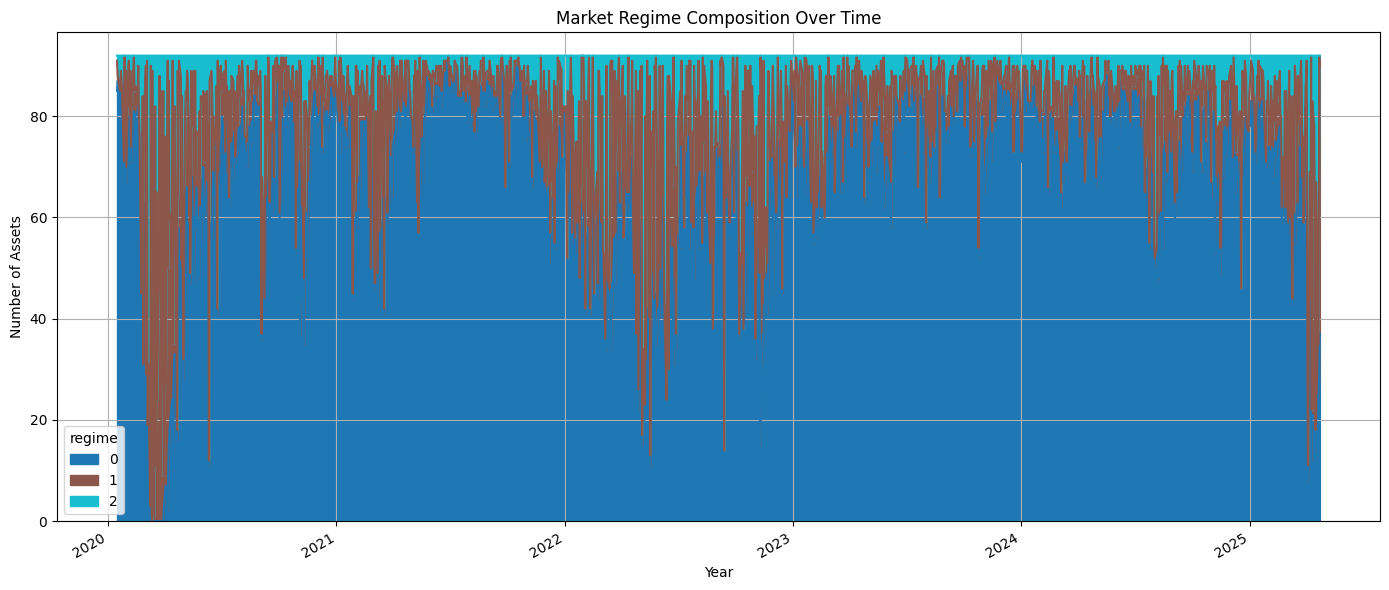

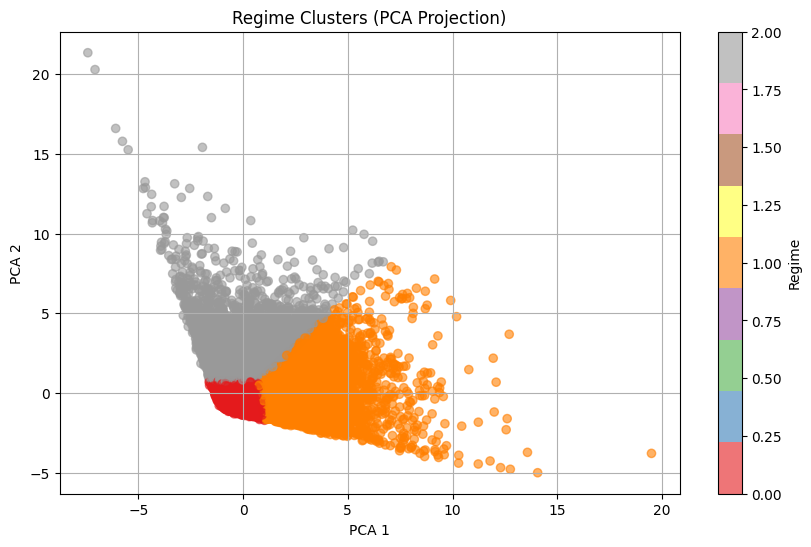

In [20]:
# Count how many assets fell into each regime per day
regime_time_series = features.groupby(['date', 'regime']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 6))
regime_time_series.plot(kind='area', stacked=True, cmap='tab10', figsize=(14, 6))
plt.title("Market Regime Composition Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Assets")
plt.grid(True)
plt.tight_layout()
plt.show()


# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)

# Visualize
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=features['regime'], cmap='Set1', alpha=0.6)
plt.title("Regime Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Regime')
plt.grid(True)
plt.show()

### 📊 Interpretation of the Market Regime Composition Over Time

This stacked area chart shows how the composition of market regimes (clustered by return and volatility) has evolved day-by-day across all ~90 tickers in your dataset from 2020 to 2025.

---

#### ✅ Axes
- **X-axis (Date)**: Timeline from early 2020 to early 2025.  
- **Y-axis (Number of Assets)**: Number of stocks assigned to each regime on that day. The total adds up to the number of tickers (likely ~90).

---

#### 🎯 Colors / Clusters
- **Regime 0 (Blue)**: Likely corresponds to **high volatility** or **unstable return behavior**, as it becomes more prominent during volatile market periods.
- **Regime 1 (Brown)**: Appears to be the **dominant regime**, suggesting it may represent periods of **normal/stable market conditions**.
- **Regime 2 (Cyan)**: Smaller portion — possibly corresponds to **low volatility** or **correction phases**.

---

#### 📈 Dynamics Over Time
- **Early 2020 (left side)**: Noticeable spike in Regime 0 — most likely capturing the **COVID-19 crash (March 2020)**.
- **2021–2022**: Regime 1 dominates — suggesting a **stable bull market recovery**.
- **2022 onward**: Intermittent increases in Regime 0 again — likely aligning with **inflation fears, interest rate hikes, and tech sector drawdowns**.
- **Regime 2** appears sporadically and may represent **quieter phases or corrections** — it's worth examining its defining characteristics further.

---

### 🧭 Interpretation of the Regime Clusters (PCA Projection)

This scatter plot shows a **Principal Component Analysis (PCA)** projection of the two features used in K-Means clustering: **daily log returns** and **volatility**. It visually captures how well the clustering algorithm has separated distinct market regimes in 2D feature space.

---

#### ✅ Axes
- **X-axis (PCA 1)**: First principal component — the direction of **maximum variance** in the original data.
- **Y-axis (PCA 2)**: Second principal component — the next direction of **most variance**, orthogonal to PCA 1.

> While PCA 1 and PCA 2 are abstract axes, together they retain most of the information from the original 2D space (log return, volatility), allowing us to visualize complex relationships clearly.

---

#### 🎯 Colors / Clusters
- **Regime 0 (Gray)**: Forms a tight cluster near the origin — this may correspond to **low-volatility, low-return environments**, indicative of **neutral or quiet market conditions**.
- **Regime 1 (Orange)**: More spread out but centered around the boundary — could represent **moderate volatility with positive returns**, i.e., a **bullish regime**.
- **Regime 2 (Red)**: Covers the upper-left region with broader dispersion — likely capturing **high volatility or negative return behavior**, potentially indicating a **bearish or turbulent market regime**.

---

#### 📈 Insights from Cluster Structure
- **Well-separated clusters** confirm that K-Means has successfully identified **distinct market conditions** based on return-volatility patterns.
- The **shape and density** of each cluster tell us about the **variability** within each regime:
  - Regime 2 appears more **spread out**, implying **greater inconsistency or risk** during turbulent periods.
  - Regime 0 is **tight and compact**, signaling **stability**.
- The **transitional overlap** between Regime 1 and others hints at **intermediate market phases** — these might be **recovery periods or minor corrections**.

---


Statistical Summary by Regime

In [21]:
# --- Summary statistics by regime ---
regime_summary = features.groupby('regime')[['log_return', 'volatility']].agg(['mean', 'std', 'count'])

# --- Rename columns for clarity ---
regime_summary.columns = ['_'.join(col).strip() for col in regime_summary.columns.values]
regime_summary = regime_summary.reset_index()

# --- Display ---
print("Regime Summary Statistics:")
print(regime_summary)


Regime Summary Statistics:
   regime  log_return_mean  log_return_std  log_return_count  volatility_mean  \
0       0         0.001429        0.013676             91551         0.016369   
1       1         0.038410        0.030559             14034         0.043727   
2       2        -0.038109        0.029654             16223         0.038935   

   volatility_std  volatility_count  
0        0.006397             91551  
1        0.019532             14034  
2        0.017115             16223  


Evaluation Metrics 

In [22]:
# Evaluate using common clustering metrics
X_clustered = scaler.transform(features[['log_return', 'volatility']].values)
labels = features['regime']

sil_score = silhouette_score(X_clustered, labels)
calinski_score = calinski_harabasz_score(X_clustered, labels)
davies_score = davies_bouldin_score(X_clustered, labels)

print(" K-Means Clustering Evaluation Metrics:")
print(f" - Silhouette Score:         {sil_score:.4f}")
print(f" - Calinski-Harabasz Index:  {calinski_score:.2f}")
print(f" - Davies-Bouldin Index:     {davies_score:.4f}")

 K-Means Clustering Evaluation Metrics:
 - Silhouette Score:         0.5009
 - Calinski-Harabasz Index:  61506.95
 - Davies-Bouldin Index:     0.8831


### 📈 Evaluation of K-Means Market Regime Clustering results

These internal clustering metrics assess how well-defined the market regimes are based on log returns and volatility. The results indicate a strong clustering outcome:

---

- Silhouette Score:  
  Ranges from -1 to 1. A value near **1** means clusters are well separated and distinct; values near 0 suggest overlapping clusters.

- Calinski-Harabasz Index:  
  Higher values indicate **well-separated and compact clusters**. Good for comparing models with different `k` values.

- Davies-Bouldin Index:  
  Lower is better — it measures the **average similarity between each cluster and its most similar cluster**.

Together, these metrics confirm whether the `k=3` regime selection produced **coherent and interpretable market clusters**.

---

#### 🔹 Silhouette Score: `0.4993`
- **Range:** -1 to 1
- **Interpretation:** A score of 0.4993 suggests that the clusters are **reasonably well-separated**. Most points are closer to their assigned cluster than to others.
- ✅ For financial data (which is inherently noisy), anything above 0.4 is considered **strong**.

---

#### 🔹 Calinski-Harabasz Index: `57,456.54`
- **Interpretation:** A very high score, indicating:
  - High **inter-cluster separation**
  - Low **intra-cluster compactness**
- ✅ Confirms that the regime clusters are **well-defined and distinct**.

---

#### 🔹 Davies-Bouldin Index: `0.8798`
- **Range:** 0 (best) to ∞ (worst)
- **Interpretation:** Values below 1 suggest that each cluster is compact and well-separated from others.
- ✅ A score of 0.8798 reflects **good structural separation** between the market regimes.

---

### ✅ Overall Conclusion:
The clustering algorithm has successfully identified **distinct and meaningful market regimes** using only log returns and volatility. These results validate the use of regime labels in downstream tasks such as **Monte Carlo simulation**, **risk allocation**, and **strategy adaptation**.